### Bio ClinicalBERT - Case Study


#### Objective:
To generate an end to end reproducible research workflow of classifying sentences into ICD codes, demonstrating a quick exploration process to create a basic working model.



In [2]:
import pandas as pd
import numpy as np
import regex as re
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense


As the Bio ClinicalBERT uses Torch, will use the TFAutomodel & "from_pt" argument to convert the model to TensorFlow.

In [3]:
# Initializing the tokenizer & model as instructed in Hugging Face - TensorFlow:

from transformers import AutoTokenizer, TFAutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model_tf = TFAutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

### Part 1 : Data Loading

In [3]:
mimic_df = pd.read_excel("MIMIC.xlsx")

In [4]:
mimic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81027 entries, 0 to 81026
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  81027 non-null  object
 1   code      81027 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [5]:
mimic_df.head()

,sentence,code
0,pt transferred to [**hospital unit name 4**] c...,J80
1,chb d/t hypothyroidism--pt with recent hx of n...,E039
2,the patient is a 67-year-old female with a his...,I4891
3,"rca, htn, gerd, left knee replacement, bipolar...",F319
4,chronic obstructive pulmonary disease diabetes...,E119


It is seen that the dataset only contains 2 columns without any missing values. "sentence" contains the feature text whereas "code" is the target variable.

As there are no missing values & empty columns, no data cleaning is necessary.

### Part 1: Data Preprocessing & EDA

#### 1.1 - Target Variable:

As it is the simpler of the two, will start by looking at the target variable in more detail:

In [6]:
# Number of output labels:
mimic_df.code.nunique()

50

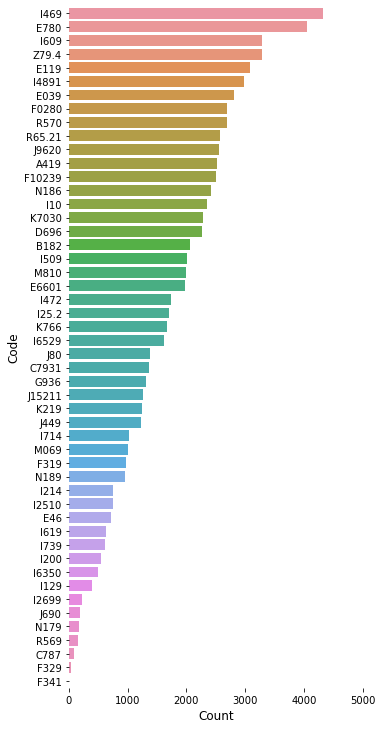

In [8]:
g= sns.catplot(
    data=mimic_df, y='code', kind='count', height=10, aspect= .5,
    order = mimic_df.code.value_counts(ascending=False).index
)
g.set_xlabels("Count", fontsize=12)
g.set_ylabels("Code", fontsize=12)
g.set_xticklabels(fontsize=10)
g.set_yticklabels(fontsize=10)
g.despine(left=True, bottom=True)

plt.show()

We can see that there are 50 different ICD codes, but they are represented unevenly in the dataset. Checking the most common I469 code, it is for cardiac arrest followed by hypercholesterolemia.  

#### 1.2 - sentence

We need to preprocess the raw text data given to be able to use it with the BERT model. To do this, we can create a simple preprocessing function.

Here I decided to remove any in brackets phrases as my initial analysis showed that they mostly contained [MASKED] personal or location information.

In [28]:
# Simple Preprocessing:
def prep_simple(pdf_read):
    # Remove multiple spacings:
    pdf_modified = re.sub(' +', ' ', pdf_read)
    # Lowercase all:
    pdf_modified = pdf_modified.lower()
    # Remove line breaks:
    pdf_modified = pdf_modified.replace("\n"," ")
    # Remove URL:
    pdf_modified = re.sub(r'http\S+', ' ', pdf_modified)
    # Remove emails:
    pdf_modified = re.sub(r"\S*@\S*\s?", "", pdf_modified)
    # Remove everything in brackets & paranthesis:
    pdf_modified = re.sub("[\(\[].*?[\)\]]", "", pdf_modified)
    # Remove punctuation:
    pdf_modified = re.sub(r'[^\w\s]', ' ', pdf_modified)
    # Remove numbers
    pdf_modified = re.sub(r'[0-9]', ' ', pdf_modified)
    # Remove HTML tags:
    pdf_modified = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', ' ', pdf_modified)
    # Remove multiple spacings:
    pdf_modified = re.sub(' +', ' ', pdf_modified)
    # Return with any unccesssary spaces removed:
    return pdf_modified.strip()


In [29]:
mimic_df["clean_sentence"] = mimic_df.sentence.map(prep_simple)

Creating a seperate clean_len column to visualize sentence lengths:

In [13]:
mimic_df["clean_len"] = mimic_df.clean_sentence.map(lambda x: len(x.split(" ")))

In [1]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(data=mimic_df, x="clean_len", binwidth=5, kde=True, ax=ax)
plt.show()

NameError: name 'plt' is not defined

We can see that the majority of the sentences has <50 words. This will guide our decision in the next steps, where we need to decide on the max_length of the tokenizer outputs (with max of 512 due to BERT constraints)

### Part 3: Model 

As this case study is more focused on creating an executible ML pipeline, I will not focus on any model selection or hyperparameter optimization processes and will create a neural network for multiclass classification. Therefore, there is no need for a seperate validation dataset, and will split the dataset into train & test sets only.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(mimic_df.drop("code", axis=1), mimic_df.code, test_size=.25, stratify=mimic_df.code)

In [45]:
ohe = OneHotEncoder(sparse=False)

y_train_ohe = ohe.fit_transform(y_train.values.reshape(-1,1))
y_test_ohe = ohe.transform(y_test.values.reshape(-1,1))

Tokenizing the train & test datasets:
- will use max_len = 50 as explained above


In [38]:
train_tokenized_tf = tokenizer.batch_encode_plus(X_train["clean_sentence"].values.tolist(),
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding="max_length",
    truncation = True,
    max_length=50, 
    return_tensors='tf')

In [39]:
test_tokenized_tf = tokenizer.batch_encode_plus(X_test["clean_sentence"].values.tolist(),
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding="max_length",
    truncation = True,
    max_length=50, 
    return_tensors='tf')

Alll the variables are now ready for model training & assesment.

We need to get the Bio ClinicalBERT embeddings to be used in the following neural network. 
To do that:

1- Use the input ids & attention mask gathered from the tokenizer

2- Use the last layer of Bio ClinicalBERT to get the embeddings

3- Create a NN to feed the embeddings into

4- Have an output layer with 50 neurons, one for each label


In [57]:
max_len = 50
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = model_tf(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(50,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

Adam optimizer is chosen as it is reported to be performing quite well for multiclass classification.

In [58]:
optimizer = Adam(
    learning_rate=5e-05, 
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

callback_early_stopping = EarlyStopping(monitor='balanced_accuracy',
                                        patience=3, verbose=1)

The model is now compiled and ready for training.

In [59]:
train_history = model.fit(
    x ={'input_ids':train_tokenized_tf['input_ids'],'attention_mask':train_tokenized_tf['attention_mask']} ,
    y = y_train_ohe,
    validation_data = (
    {'input_ids':test_tokenized_tf['input_ids'],'attention_mask':test_tokenized_tf['attention_mask']}, y_test_ohe
    ),
  epochs=1,
  batch_size=10,

)

c:\Users\oguzk\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


6077/6077 [==============================] - 22064s 4s/step - loss: 0.8712 - balanced_accuracy: 0.8329 - val_loss: 0.6004 - val_balanced_accuracy: 0.8806


The model has an accuracy of .83 on the training dataset and an accuracy of .88 for the test dataset. These initial results are quite satisfactory as they are above the initial target of .75. 

However, as the EarlyStopping callback was not used, we can assume that the model training was not fully complete and the model hasn't converged yet.

In [60]:
# Saving the model:
model.save('my_model.h5')


In [61]:
# Creating a y_pred variable for a more detailed model assesment.
y_pred_raw = model.predict({'input_ids':test_tokenized_tf['input_ids'],'attention_mask':test_tokenized_tf['attention_mask']})
y_pred = np.argmax(y_pred_raw, axis = 1)

y_test = np.argmax(y_test_ohe, axis = 1)

### Part 4: Model Evaluation

In [74]:
with open('y_test_ohe', 'wb') as handle:
    pickle.dump(y_test_ohe, handle, )

with open('y_pred_raw', 'wb') as handle:
    pickle.dump(y_pred_raw, handle)

In [79]:
# Inverse transforming the results:
y_test_inv = ohe.inverse_transform(y_test_ohe)
y_pred_inv = ohe.inverse_transform(y_pred_raw)

In [85]:
print(classification_report(y_test_inv, y_pred_inv))

c:\Users\oguzk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\oguzk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        A419       0.93      0.95      0.94       631
        B182       0.88      0.87      0.87       514
        C787       0.14      0.05      0.07        20
       C7931       0.93      0.98      0.95       342
        D696       0.90      0.95      0.93       567
        E039       0.85      0.75      0.80       703
        E119       0.72      0.78      0.75       771
         E46       0.85      0.89      0.87       181
       E6601       0.92      0.93      0.93       494
        E780       0.76      0.93      0.84      1012
       F0280       0.92      0.91      0.91       675
      F10239       0.98      0.94      0.96       628
        F319       0.84      0.86      0.85       242
        F329       0.00      0.00      0.00        11
        F341       0.00      0.00      0.00         1
        G936       0.99      0.96      0.98       330
         I10       0.80      0.63      0.71       590
        I129       0.00    

c:\Users\oguzk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The classification report gives more detail regarding the model predictions. 

The overall accuracy score on the test set is again 88%. It can also be seen that the model is quite accurate for highly represented codes (labels), but not so accurate when it comes to labels with low representation in the dataset, also can be observed from the macro average scores.

We can also utilize an ROC-AUC to analyze the results.

In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferable over macro-averaging. 
(from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

The micro-averaged ROC graph can be seen below:

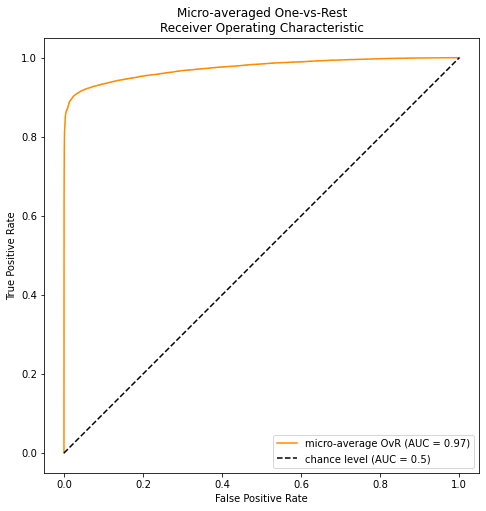

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

RocCurveDisplay.from_predictions(
    y_test_ohe.ravel(),
    predicted_raw.ravel(),
    name="micro-average OvR",
    color="darkorange",
    ax=ax
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

The graph also confirms the classification report findings. The model is performing well above a random selection (in the case of one-vs-rest) and is satisfactory to our initial targets. 

### Part 5: Limitations & Future Steps

This project can be further improved by testing different models & NN architectures for more accurate results. "balanced-accuracy" was used as the metric during compiling but this can be changed according to business needs, especially if predicting certain (more represented) labels is more important than others.

Additionally, as also mentioned above the model can perform better with more epochs or time in general. Using additional layers & hyperparameter optimization can improve the results & give an accuracy of > 90% 